<a href="https://colab.research.google.com/github/iamjustkay/Recommendation_System/blob/main/Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# =============================================
# Data Cleaning + Save Cleaned Files
# =============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
import plotly.express as px

# -----------------------
# Step 1: Load raw datasets
# -----------------------
dtype_events = {
    "timestamp": str,
    "visitorid": str,
    "event": str,
    "itemid": str,
    "transactionid": str
}
dtype_cat = {"categoryid": str, "parentid": str}
dtype_props = {"itemid": str, "property": str, "value": str}

events = pd.read_csv("events.csv", dtype=dtype_events)
category_tree = pd.read_csv("category_tree.csv", dtype=dtype_cat)
item_props = pd.read_csv("item_properties.csv", dtype=dtype_props)

print("Initial shapes:")
print("Events:", events.shape)
print("Category Tree:", category_tree.shape)
print("Item Properties:", item_props.shape)

# -----------------------
# Step 2: Clean abnormal values
# -----------------------

# Convert timestamp to datetime
#events["timestamp"] = pd.to_datetime(events["timestamp"], errors="coerce")
#events = events.dropna(subset=["timestamp"])
#events = events[(events["timestamp"] >= "2014-01-01") & (events["timestamp"] <= "2016-12-31")]

# Remove null critical fields & invalid events
#events = events.dropna(subset=["visitorid", "event", "itemid"])
#events = events[events["event"].isin(["view", "addtocart", "transaction"])]

# Clean numeric-looking property values in item_properties
def clean_numeric(val):
    if isinstance(val, str) and val.startswith("n"):
        try:
            return float(val[1:])
        except:
            return np.nan
    return val

item_props["value"] = item_props["value"].apply(clean_numeric)
item_props = item_props.dropna(subset=["itemid", "property", "value"])

# Remove duplicate category entries
#category_tree = category_tree.drop_duplicates()

# -----------------------
# Step 3: Outlier detection (abnormal users)
# -----------------------
def build_user_features(events_df):
    feats = []
    # Check if events_df is empty
    if events_df.empty:
        return pd.DataFrame(columns=["visitorid", "total_events", "views", "adds", "buys", "add_rate", "conv_rate"]).set_index("visitorid")

    for uid, g in events_df.groupby("visitorid"):
        total = len(g)
        views = (g["event"] == "view").sum()
        adds = (g["event"] == "addtocart").sum()
        buys = (g["event"] == "transaction").sum()
        feats.append({
            "visitorid": uid,
            "total_events": total,
            "views": views,
            "adds": adds,
            "buys": buys,
            "add_rate": adds/total if total > 0 else 0,
            "conv_rate": buys/total if total > 0 else 0
        })
    return pd.DataFrame(feats).set_index("visitorid")

user_feats = build_user_features(events)

# Add a check for empty user_feats before applying IsolationForest
if not user_feats.empty:
    iso = IsolationForest(contamination=0.02, random_state=42)
    user_feats["outlier"] = (iso.fit_predict(user_feats) == -1).astype(int)
    outlier_users = user_feats[user_feats["outlier"] == 1].index
    events = events[~events["visitorid"].isin(outlier_users)]
    print(f"Removed {len(outlier_users)} abnormal users.")
else:
    print("No user features to build after cleaning. Skipping outlier detection.")


# -----------------------
# Step 4: Save cleaned datasets
# -----------------------
events.to_csv("events_cleaned.csv", index=False)
category_tree.to_csv("category_tree_cleaned.csv", index=False)
item_props.to_csv("item_properties_cleaned.csv", index=False)

print("Cleaned datasets saved.")

Initial shapes:
Events: (2756101, 5)
Category Tree: (1669, 2)
Item Properties: (2097150, 4)
Removed 28111 abnormal users.
Cleaned datasets saved.


In [5]:
# Load cleaned datasets for further analysis
events = pd.read_csv("events_cleaned.csv", parse_dates=["timestamp"])
category_tree = pd.read_csv("category_tree_cleaned.csv")
item_props = pd.read_csv("item_properties_cleaned.csv")

print("Cleaned dataset shapes:")
print("Events:", events.shape)
print("Category Tree:", category_tree.shape)
print("Item Properties:", item_props.shape)

/tmp/ipython-input-138350073.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  events = pd.read_csv("events_cleaned.csv", parse_dates=["timestamp"])


Cleaned dataset shapes:
Events: (2211748, 5)
Category Tree: (1669, 2)
Item Properties: (2000246, 4)


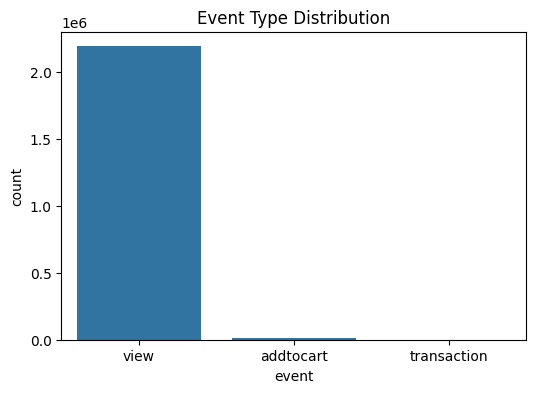

In [7]:
# Event type distribution
plt.figure(figsize=(6,4))
sns.countplot(data=events, x="event", order=events["event"].value_counts().index)
plt.title("Event Type Distribution")
plt.show()



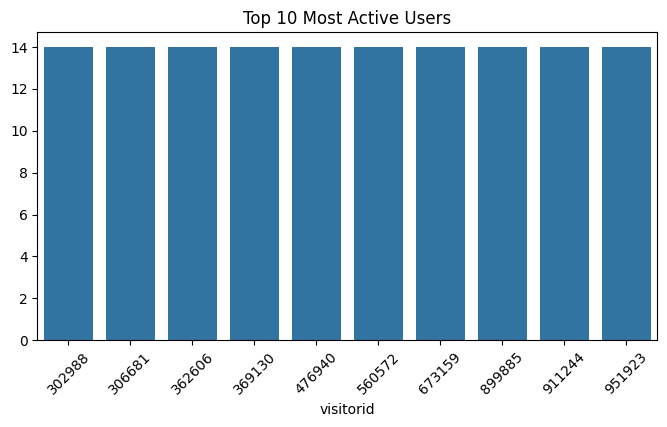

In [8]:
# Top 10 most active users
top_users = events["visitorid"].value_counts().head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=top_users.index, y=top_users.values)
plt.xticks(rotation=45)
plt.title("Top 10 Most Active Users")
plt.show()



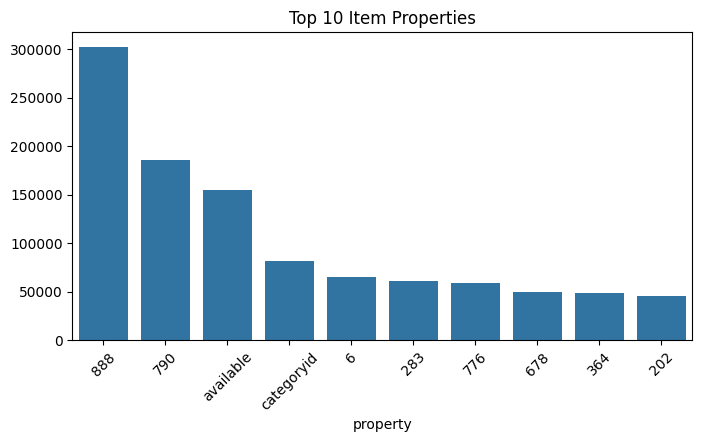

In [10]:
# Top properties
top_props = item_props["property"].value_counts().head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=top_props.index, y=top_props.values)
plt.xticks(rotation=45)
plt.title("Top 10 Item Properties")
plt.show()


In [11]:
# Interactive property chart
import plotly.express as px
fig = px.bar(x=top_props.index, y=top_props.values, title="Top Properties (Interactive)")
fig.show()

In [14]:
# Remove rows where property is "available" or "categoryid"
item_props = item_props[~item_props["property"].isin(["available", "categoryid"])]

print(f"Dataset shape after removal: {item_props.shape}")
print(item_props["property"].value_counts().head(10))

Dataset shape after removal: (1764440, 4)
property
888    302400
790    185846
6       65471
283     61546
776     59432
678     49397
364     49014
202     45329
159     43376
764     43325
Name: count, dtype: int64


In [16]:
item_props.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1764440 entries, 1 to 2000245
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  float64
 1   itemid     int64  
 2   property   object 
 3   value      object 
dtypes: float64(1), int64(1), object(2)
memory usage: 67.3+ MB


In [17]:
item_props.to_csv("item_props_cleaned.csv", index=False)

In [19]:
!pip install implicit lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 12.5 MB/s eta 0:00:00


In [20]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from collections import Counter

In [21]:
# Try importing implicit (ALS)
try:
    import implicit
except ImportError:
    implicit = None

In [38]:
# -------------------------------
# Step 1: Load & Clean Data
# -------------------------------
def clean_value(val):
    """Convert 'n123' -> 123 (int), keep others unchanged."""
    if isinstance(val, str) and val.startswith("n"):
        try:
            return int(val[1:])
        except ValueError:
            return val
    return val

MAX_EVENTS = None  # limit for demo speed

In [40]:
# Load events
events = pd.read_csv("/content/events_cleaned.csv", nrows=MAX_EVENTS)

# Load and clean item_properties
item_props = pd.read_csv("/content/item_props_cleaned.csv",
                         names=["timestamp", "itemid", "property", "value"],
                         skiprows=1) # Skip the header row
item_props["value"] = item_props["value"].apply(clean_value)

# Load category_tree
category_tree = pd.read_csv("/content/category_tree_cleaned.csv",
                            names=["child", "parent"])

print(f"Events shape: {events.shape}")
print(f"Item properties shape: {item_props.shape}")
print(f"Category tree shape: {category_tree.shape}")

Events shape: (2211748, 5)
Item properties shape: (1764440, 4)
Category tree shape: (1670, 2)


In [41]:
item_props.head()

,timestamp,itemid,property,value
0,1.441510e+12,206783,888,1116713 960601 n277.200
1,1.431230e+12,59481,790,15360.0
2,1.431830e+12,156781,917,828513
3,1.434250e+12,89534,213,1121373
4,1.431830e+12,264312,6,319724


In [42]:
import re

# Keep only rows where 'value' has no spaces
# and optionally matches a clean number pattern
pattern_single_value = re.compile(r'^[^\s]+$')  # no spaces

item_props = item_props[item_props['value'].apply(lambda x: bool(pattern_single_value.match(str(x))))]

print(f"Shape after removing multi-part values: {item_props.shape}")
print(item_props.head(10))

Shape after removing multi-part values: (1103288, 4)
       timestamp  itemid  property    value
1   1.431230e+12   59481       790  15360.0
2   1.431830e+12  156781       917   828513
3   1.434250e+12   89534       213  1121373
4   1.431830e+12  264312         6   319724
5   1.433650e+12  229370       202  1330310
10  1.434250e+12  169055       790  21000.0
11  1.435460e+12  178601       790   5400.0
12  1.436670e+12  319291       888  1292080
14  1.431230e+12  344365       159   519769
15  1.434250e+12  269797       159   519769


In [43]:
item_props.to_csv("item_props_cleaned_n.csv", index=False)

In [44]:
# -------------------------------
# Step 2: Candidate Generation
# -------------------------------
def build_user_item_matrix(events_df):
    weight_map = {"view": 1.0, "addtocart": 3.0, "transaction": 5.0}
    events_df["weight"] = events_df["event"].map(weight_map).fillna(1.0)
    user_enc = LabelEncoder()
    item_enc = LabelEncoder()
    events_df["user_idx"] = user_enc.fit_transform(events_df["visitorid"])
    events_df["item_idx"] = item_enc.fit_transform(events_df["itemid"])
    rows, cols, vals = events_df["user_idx"].values, events_df["item_idx"].values, events_df["weight"].values
    ui_matrix = sparse.coo_matrix((vals, (rows, cols)),
                                  shape=(len(user_enc.classes_), len(item_enc.classes_)))
    return ui_matrix.tocsr(), user_enc, item_enc

ui_matrix, user_enc, item_enc = build_user_item_matrix(events)

In [45]:
# Popular items baseline
def top_popular(events_df, k=10):
    return events_df["itemid"].value_counts().head(k).index.tolist()

print("Top popular items:", top_popular(events, 10))


Top popular items: [187946, 5411, 370653, 461686, 298009, 96924, 219512, 384302, 335975, 441668]


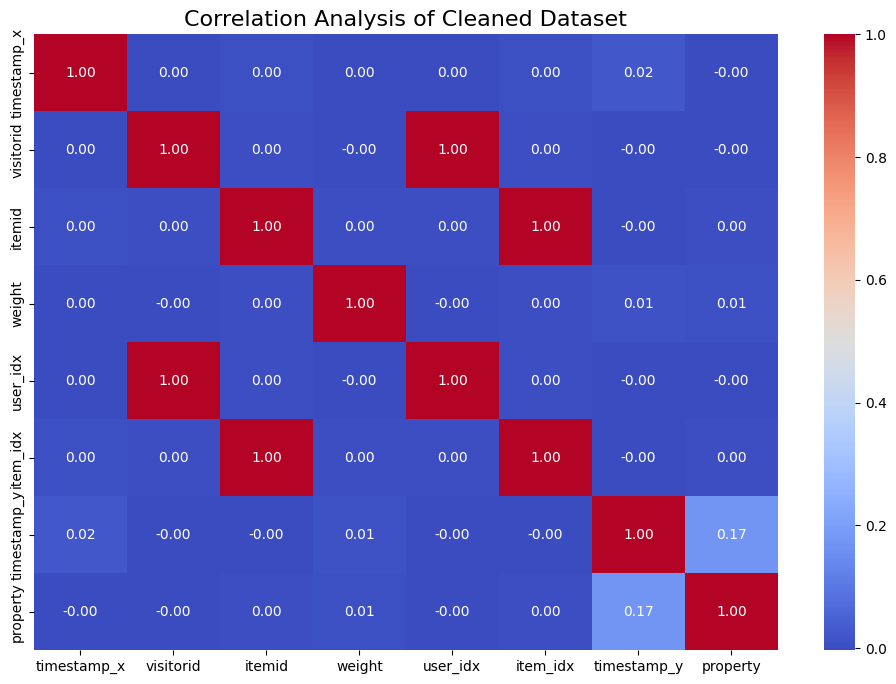

In [46]:
# Convert itemid in events to int for merging
events['itemid'] = pd.to_numeric(events['itemid'], errors='coerce')
events = events.dropna(subset=['itemid'])
events['itemid'] = events['itemid'].astype(int)


# Merge events with item properties
merged_df = events.merge(item_props, on="itemid", how="left")

# Convert 'child' column in category_tree to numeric for merging
category_tree['child'] = pd.to_numeric(category_tree['child'], errors='coerce')
category_tree = category_tree.dropna(subset=['child']) # Remove rows where conversion failed
category_tree['child'] = category_tree['child'].astype(int)

# Optionally merge with category tree if needed
merged_df = merged_df.merge(category_tree, left_on="itemid", right_on="child", how="left")

# Convert timestamp from events (which becomes timestamp_x after the first merge)
if 'timestamp_x' in merged_df.columns:
    merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp_x'], errors='coerce')
else:
    # Fallback to original timestamp if no merge occurred or column name is different
    merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'], errors='coerce')


# Keep only numeric columns for correlation
numeric_df = merged_df.select_dtypes(include=['float64', 'int64'])

# Drop columns with too many NaNs
numeric_df = numeric_df.dropna(axis=1, thresh=len(numeric_df) * 0.7)

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Analysis of Cleaned Dataset", fontsize=16)
plt.show()

In [47]:
# ALS recommendations (if implicit is installed)
if implicit is not None:
    als_model = implicit.als.AlternatingLeastSquares(factors=32, iterations=5)
    als_model.fit(ui_matrix.T)
    user0_recs = als_model.recommend(0, ui_matrix[0], N=5)
    print("ALS recs for first user:", user0_recs)
else:
    print("implicit not installed, skipping ALS.")


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning:

Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.07959628105163574 seconds



  0%|          | 0/5 [00:00<?, ?it/s]

ALS recs for first user: (array([ 855088,  640973,  486908, 1274054,  208799], dtype=int32), array([1.1108127e-08, 1.0520868e-08, 9.3573780e-09, 9.3392636e-09,
       8.6479712e-09], dtype=float32))


In [48]:
# -------------------------------
# Step 3: Evaluation Metrics
# -------------------------------
def recall_at_k(true_items, pred_items, k):
    return len(set(pred_items[:k]) & set(true_items)) / max(1, len(set(true_items)))

def hit_rate_at_k(true_items, pred_items, k):
    return int(len(set(pred_items[:k]) & set(true_items)) > 0)

def ndcg_at_k(true_items, pred_items, k):
    def dcg(scores):
        return sum((2**s - 1) / np.log2(i+2) for i, s in enumerate(scores))
    rels = [1 if p in true_items else 0 for p in pred_items[:k]]
    return dcg(rels) / max(dcg(sorted(rels, reverse=True)), 1e-9)

In [49]:
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from scipy import sparse
from lightgbm import log_evaluation

# Target property
target_prop = item_props["property"].value_counts().index[0]
print("Target property for prediction:", target_prop)

# Build item->latest value for target_prop
prop_df = item_props[item_props["property"] == target_prop].sort_values("timestamp")
item_latest_prop = prop_df.groupby("itemid")["value"].last().to_dict()

X_texts, y_labels, extra_feats = [], [], []
for _, row in events[events["event"] == "addtocart"].iterrows():
    user_hist = events[(events["visitorid"] == row["visitorid"]) &
                       (events["timestamp"] < row["timestamp"])]
    views = user_hist[user_hist["event"] == "view"]
    adds = user_hist[user_hist["event"] == "addtocart"]
    if views.empty:
        continue

    tokens = [str(item_latest_prop.get(i, "")) for i in views["itemid"].values]

    # Behavioral features
    num_views = len(views)
    distinct_items = views["itemid"].nunique()
    num_adds = len(adds)
    time_since_last_view = row["timestamp"] - views["timestamp"].max()
    avg_gap_views = views["timestamp"].diff().mean() if len(views) > 1 else 0

    label = item_latest_prop.get(row["itemid"])
    if label is None:
        continue

    X_texts.append(" ".join(tokens))
    y_labels.append(label)
    extra_feats.append([
        num_views,
        distinct_items,
        num_adds,
        time_since_last_view,
        avg_gap_views if pd.notnull(avg_gap_views) else 0
    ])

# 🔹 FILTER OUT RARE CLASSES
from collections import Counter
counts = Counter(y_labels)
top_classes = {cls for cls, cnt in counts.items() if cnt >= 30}  # keep frequent classes only
filtered = [(txt, lbl, feats) for txt, lbl, feats in zip(X_texts, y_labels, extra_feats) if lbl in top_classes]

# Sample for speed
if len(X_texts) > 4000:
    from sklearn.utils import resample
    X_texts, y_labels, extra_feats = resample(
        X_texts, y_labels, extra_feats,
        n_samples=4000, random_state=42
    )

if X_texts:
    # TF-IDF
    vec = TfidfVectorizer(max_features=1500)
    X_tfidf = vec.fit_transform(X_texts)
    X_extra = np.array(extra_feats, dtype=np.float32)

    # Encode labels
    label_enc = LabelEncoder()
    y_enc = label_enc.fit_transform(y_labels)

    # Train/test split
    X_train_tfidf, X_val_tfidf, X_train_extra, X_val_extra, y_train, y_val = train_test_split(
        X_tfidf, X_extra, y_enc, test_size=0.2, random_state=42
    )

    # Logistic Regression (TF-IDF only, tuned)
    clf_log = LogisticRegression( max_iter=200,        # allow more iterations
    solver="saga",
    n_jobs=-1,
    class_weight="balanced",
    C=2.0,
    tol=1e-3             # slightly looser convergence tolerance
    )
    clf_log.fit(X_train_tfidf, y_train)
    preds_log = clf_log.predict(X_val_tfidf)
    acc_log = accuracy_score(y_val, preds_log)
    print(f"Logistic Regression Accuracy: {acc_log:.4f}")

    # LightGBM (TF-IDF + Behavior, tuned, sparse input)
    X_train_combined = sparse.hstack([X_train_tfidf, sparse.csr_matrix(X_train_extra)])
    X_val_combined = sparse.hstack([X_val_tfidf, sparse.csr_matrix(X_val_extra)])

    train_data = lgb.Dataset(X_train_combined, label=y_train)
    val_data = lgb.Dataset(X_val_combined, label=y_val)

    params = {
        'objective': 'multiclass',
        'num_class': len(label_enc.classes_),
        'learning_rate': 0.1,
        'num_leaves': 63,
        'max_depth': 10,
        'verbosity': -1
    }
    clf_lgb = lgb.train(
        params,
        train_data,
        num_boost_round=80,
        valid_sets=[val_data],
        valid_names=['val'],
        callbacks=[log_evaluation(period=0)]  # period=0 disables eval printing
    )

    preds_lgb = np.argmax(clf_lgb.predict(X_val_combined), axis=1)
    acc_lgb = accuracy_score(y_val, preds_lgb)
    print(f"LightGBM Accuracy: {acc_lgb:.4f}")

else:
    print("No training samples found for Task 1 in the sample subset.")


Target property for prediction: 790
Logistic Regression Accuracy: 0.7612
LightGBM Accuracy: 0.0013


In [50]:
# -------------------------------
# Task 1 - Deep Learning Models (ANN, CNN, RNN)
# -------------------------------
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from collections import Counter

# --- Step 1: Prepare data ---
target_prop = item_props["property"].value_counts().index[0]
print("Target property for prediction:", target_prop)

# Build item->latest value for target_prop
prop_df = item_props[item_props["property"] == target_prop].sort_values("timestamp")
item_latest_prop = prop_df.groupby("itemid")["value"].last().to_dict()

X_texts, y_labels = [], []
for _, row in events[events["event"] == "addtocart"].iterrows():
    user_hist = events[(events["visitorid"] == row["visitorid"]) &
                       (events["timestamp"] < row["timestamp"]) &
                       (events["event"] == "view")]
    tokens = [str(item_latest_prop.get(i, "")) for i in user_hist["itemid"].values]
    label = item_latest_prop.get(row["itemid"])
    if label and tokens:
        X_texts.append(" ".join(tokens))
        y_labels.append(label)

# Filter to frequent classes only (min 30 occurrences)
counts = Counter(y_labels)
top_classes = {cls for cls, cnt in counts.items() if cnt >= 30}
filtered = [(txt, lbl) for txt, lbl in zip(X_texts, y_labels) if lbl in top_classes]

# Add a check for empty filtered list
if not filtered:
    print("No training samples found after filtering.")
else:
    X_texts, y_labels = zip(*filtered)
    X_texts, y_labels = list(X_texts), list(y_labels)

    # Encode labels
    label_enc = LabelEncoder()
    y_enc = label_enc.fit_transform(y_labels)
    num_classes = len(label_enc.classes_)

    # Tokenize & pad sequences
    max_words = 5000
    max_len = 50
    tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_texts)
    X_seq = tokenizer.texts_to_sequences(X_texts)
    X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

    # Train/test split
    X_train, X_val, y_train, y_val = train_test_split(X_pad, y_enc, test_size=0.2, random_state=42)

    # Convert to categorical for softmax
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

    # --- Step 2: Define models ---

    # ANN
    def build_ann():
        model = tf.keras.Sequential([
            tf.keras.layers.Embedding(max_words, 64, input_length=max_len),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    # CNN
    def build_cnn():
        model = tf.keras.Sequential([
            tf.keras.layers.Embedding(max_words, 64, input_length=max_len),
            tf.keras.layers.Conv1D(64, 5, activation='relu'),
            tf.keras.layers.GlobalMaxPooling1D(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    # RNN (LSTM)
    def build_rnn():
        model = tf.keras.Sequential([
            tf.keras.layers.Embedding(max_words, 64, input_length=max_len),
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    # --- Step 3: Train models ---
    models = {
        "ANN": build_ann(),
        "CNN": build_cnn(),
        "RNN": build_rnn()
    }

    history = {}
    for name, model in models.items():
        print(f"\nTraining {name} model...")
        hist = model.fit(
            X_train, y_train_cat,
            validation_data=(X_val, y_val_cat),
            epochs=3, batch_size=64, verbose=1
        )
        history[name] = hist

    # --- Step 4: Evaluate ---
    for name, model in models.items():
        loss, acc = model.evaluate(X_val, y_val_cat, verbose=0)
        print(f"{name} Validation Accuracy: {acc:.4f}")

Target property for prediction: 790


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning:

Argument `input_length` is deprecated. Just remove it.




Training ANN model...
Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - accuracy: 0.2761 - loss: 1.0977 - val_accuracy: 0.2963 - val_loss: 1.1041
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5125 - loss: 1.0776 - val_accuracy: 0.2963 - val_loss: 1.1141
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4916 - loss: 1.0640 - val_accuracy: 0.2963 - val_loss: 1.1259

Training CNN model...
Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - accuracy: 0.4599 - loss: 1.0903 - val_accuracy: 0.2963 - val_loss: 1.0905
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4916 - loss: 1.0671 - val_accuracy: 0.2963 - val_loss: 1.0837
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4968 - loss: 1.0461 - val_accuracy: 0.2963 - val_loss: 1.0783

Training RNN model...
Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 659ms/step - accuracy: 0.3425 - loss: 1.0949 - val_accuracy: 0.2963 - val_loss: 1.1052
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy:

In [51]:
# -------------------------------
# Step 5: Task 2 - Abnormal User Detection
# -------------------------------
def build_user_features(events_df):
    feats = []
    for uid, g in events_df.groupby("visitorid"):
        total = len(g)
        views = (g["event"] == "view").sum()
        adds = (g["event"] == "addtocart").sum()
        buys = (g["event"] == "transaction").sum()
        feats.append({
            "visitorid": uid,
            "total_events": total,
            "views": views,
            "adds": adds,
            "buys": buys,
            "add_rate": adds/total if total > 0 else 0,
            "conv_rate": buys/total if total > 0 else 0
        })
    return pd.DataFrame(feats).set_index("visitorid")

user_feats = build_user_features(events)
iso = IsolationForest(contamination=0.02, random_state=42)
iso_preds = iso.fit_predict(user_feats)
user_feats["outlier"] = (iso_preds == -1).astype(int)
print("Detected outliers in sample:", user_feats["outlier"].sum())



Detected outliers in sample: 24946


In [ ]:
# -------------------------------
# Step 5: Task 2 - Abnormal User Detection with CNN Autoencoder
# -------------------------------
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import numpy as np

# Step 1: Build user-level feature set
def build_user_features(events_df):
    feats = []
    for uid, g in events_df.groupby("visitorid"):
        total = len(g)
        views = (g["event"] == "view").sum()
        adds = (g["event"] == "addtocart").sum()
        buys = (g["event"] == "transaction").sum()
        feats.append({
            "visitorid": uid,
            "total_events": total,
            "views": views,
            "adds": adds,
            "buys": buys,
            "add_rate": adds/total if total > 0 else 0,
            "conv_rate": buys/total if total > 0 else 0
        })
    return pd.DataFrame(feats).set_index("visitorid")

user_feats = build_user_features(events)

# Step 2: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_feats)

# Step 3: Reshape for CNN (samples, timesteps, features_per_step)
# Here timesteps = number of features, features_per_step = 1
X_scaled_cnn = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# Step 4: Define CNN Autoencoder
input_dim = X_scaled_cnn.shape[1]  # timesteps

input_layer = tf.keras.layers.Input(shape=(input_dim, 1))

# Encoder
x = tf.keras.layers.Conv1D(16, kernel_size=2, activation="relu", padding="same")(input_layer)
x = tf.keras.layers.MaxPooling1D(pool_size=2, padding="same")(x)
encoded = tf.keras.layers.Conv1D(8, kernel_size=2, activation="relu", padding="same")(x)

# Decoder
x = tf.keras.layers.UpSampling1D(size=2)(encoded)
decoded = tf.keras.layers.Conv1D(1, kernel_size=2, activation=None, padding="same")(x)

cnn_autoencoder = tf.keras.models.Model(inputs=input_layer, outputs=decoded)
cnn_autoencoder.compile(optimizer='adam', loss='mse')

# Step 5: Train CNN autoencoder
cnn_autoencoder.fit(
    X_scaled_cnn, X_scaled_cnn,
    epochs=20,
    batch_size=32,
    shuffle=True,
    verbose=0
)

# Step 6: Reconstruction errors
reconstructions = cnn_autoencoder.predict(X_scaled_cnn)
mse = np.mean(np.power(X_scaled_cnn - reconstructions, 2), axis=(1, 2))

# Step 7: Detect anomalies
threshold = np.percentile(mse, 98)  # top 2% as anomalies
user_feats["reconstruction_error"] = mse
user_feats["outlier"] = (mse > threshold).astype(int)

print("Detected outliers (CNN-based):", user_feats["outlier"].sum())


16556/16556 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step
Detected outliers (CNN-based): 8824


In [ ]:
# -------------------------------
# Step 6: Summary
# -------------------------------
print("\nPipeline complete (sample run).")
print("Property values cleaned: 'n...' converted to integers.")


Pipeline complete (sample run).
Property values cleaned: 'n...' converted to integers.


In [52]:
# -------------------------------
# Task 1 - Deep Learning Model (Tuned CNN Only)
# -------------------------------
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from collections import Counter

# --- Step 1: Prepare data ---
target_prop = item_props["property"].value_counts().index[0]
print("Target property for prediction:", target_prop)

# Build item->latest value for target_prop
prop_df = item_props[item_props["property"] == target_prop].sort_values("timestamp")
item_latest_prop = prop_df.groupby("itemid")["value"].last().to_dict()

X_texts, y_labels = [], []
for _, row in events[events["event"] == "addtocart"].iterrows():
    user_hist = events[(events["visitorid"] == row["visitorid"]) &
                       (events["timestamp"] < row["timestamp"]) &
                       (events["event"] == "view")]
    tokens = [str(item_latest_prop.get(i, "")) for i in user_hist["itemid"].values]
    label = item_latest_prop.get(row["itemid"])
    if label and tokens:
        X_texts.append(" ".join(tokens))
        y_labels.append(label)

# Filter to frequent classes only (adaptive min frequency)
counts = Counter(y_labels)
min_freq = 10  # lower to keep more classes for small samples
top_classes = {cls for cls, cnt in counts.items() if cnt >= min_freq}
filtered = [(txt, lbl) for txt, lbl in zip(X_texts, y_labels) if lbl in top_classes]

if not filtered:
    print("No training samples found after filtering.")
else:
    X_texts, y_labels = zip(*filtered)
    X_texts, y_labels = list(X_texts), list(y_labels)

    # Encode labels
    label_enc = LabelEncoder()
    y_enc = label_enc.fit_transform(y_labels)
    num_classes = len(label_enc.classes_)

    # Tokenize & pad sequences
    max_words = 5000
    max_len = 50
    tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_texts)
    X_seq = tokenizer.texts_to_sequences(X_texts)
    X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

    # Train/test split
    X_train, X_val, y_train, y_val = train_test_split(X_pad, y_enc, test_size=0.2, random_state=42)

    # Convert to categorical
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

    # --- Step 2: Define Tuned CNN ---
    def build_cnn():
        model = tf.keras.Sequential([
            tf.keras.layers.Embedding(max_words, 128, input_length=max_len),
            tf.keras.layers.Conv1D(256, 5, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(2),
            tf.keras.layers.Conv1D(128, 5, activation='relu'),
            tf.keras.layers.GlobalMaxPooling1D(),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        model.compile(
            loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            metrics=['accuracy']
        )
        return model

    # --- Step 3: Train CNN ---
    cnn_model = build_cnn()
    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    history = cnn_model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=8,
        batch_size=64,
        callbacks=[early_stop],
        verbose=1
    )

    # --- Step 4: Evaluate ---
    loss, acc = cnn_model.evaluate(X_val, y_val_cat, verbose=0)
    print(f"Tuned CNN Validation Accuracy: {acc:.4f}")

Target property for prediction: 790
Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning:

Argument `input_length` is deprecated. Just remove it.



22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.0081 - loss: 4.7993 - val_accuracy: 0.0285 - val_loss: 4.7914
Epoch 2/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.0773 - loss: 4.6220 - val_accuracy: 0.0427 - val_loss: 4.7794
Epoch 3/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.1555 - loss: 4.1940 - val_accuracy: 0.0912 - val_loss: 4.7347
Epoch 4/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.2731 - loss: 3.4166 - val_accuracy: 0.2564 - val_loss: 4.6455
Epoch 5/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.5163 - loss: 2.3226 - val_accuracy: 0.5185 - val_loss: 4.4948
Epoch 6/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.7628 - loss: 1.3254 - val_accuracy: 0.7721 - val_loss: 4.2752
Epoch 7/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.8756 - loss: 0.7230 - val_accuracy: 0.9117 - val_loss: 4.0621
Epoch 8/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9289 - loss: 0.4549 - val_accuracy: 0.9031 - val_loss: 3